In [1]:
import matplotlib.pyplot as plt
import geopandas
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import cartopy.crs as ccrs
import numpy as np

def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom')

In [4]:
municipios = geopandas.read_file('municipios/Municipios_IBGE.shp')

In [5]:
brasil = geopandas.read_file('Brasil/UFEBRASIL.shp')

In [6]:
rs = brasil[brasil['NM_ESTADO'] == 'RIO GRANDE DO SUL']

In [7]:
#rs

In [8]:
municipios.crs = "EPSG:4326"

In [9]:
lista_municipio = ['Caxias do Sul', 'Santa Maria', 'Porto Alegre', 'Pelotas']
def plot_municipios(municipios, lista_municipio, ax, c='black', delta=0.05):
    x = []
    y = []
    for index, row in municipios.iterrows():
        for m in lista_municipio:
            if row['NOME'] == m.upper():
                y.append(row['LATITUDESE'])
                x.append(row['LONGITUDES'])
    ax.scatter(x=x, y=y, marker='x', c=c)
    for i, txt in enumerate(lista_municipio[::-1]):
        ax.annotate(txt, (x[i]+delta, y[i]+delta), c=c)

In [10]:
ucs = geopandas.read_file("ucs/ucstodas.shp")
ucs.crs = "EPSG:4326"

In [11]:
#ucs.head()

In [12]:
ti = geopandas.read_file("ti_sirgas/ti_sirgasPolygon.shp")
ti.crs = "EPSG:32662"
ti = ti[ti['uf_sigla'] == 'RS']

In [13]:
#ti.head()

In [14]:
fl = geopandas.read_file("florestas/florestaspublicas.shp")
fl.crs = "EPSG:32662"

In [15]:
#fl.head()

In [16]:
sigmine = geopandas.read_file("RS/RS.shp")
sigmine.crs = "EPSG:4326"
sigmine['ANM'] = 'ANM'

In [17]:
#filtro_req1 = sigmine['FASE'] != 'REQUERIMENTO DE PESQUISA'
#filtro_req2 = sigmine['FASE'] != 'REQUERIMENTO DE LICENCIAMENTO'
#filtro_req3 = sigmine['FASE'] != 'REQUERIMENTO DE LAVRA GARIMPEIRA'
#filtro_req4 = sigmine['FASE'] != 'REQUERIMENTO DE REGISTRO DE EXTRAÇÃO'

#sigmine = sigmine[filtro_req1 & filtro_req2 & filtro_req3 & filtro_req4]

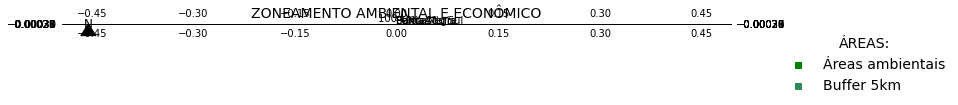

In [24]:
fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': ccrs.Mercator()})

municipios.plot(ax=ax, color='gainsboro', edgecolor='silver')

areas_amb = [ucs, ti, fl]
areas_amb = [ti]


for a in areas_amb:
    for idx, row in a.iterrows():
        p = row['geometry'].centroid
        if rs.iloc[0]['geometry'].contains(p):
             a.buffer(0.05, resolution=1).plot(ax=ax, color='seagreen')
             a.plot(ax=ax, color='green')

plt.scatter(rs.iloc[0]['geometry'].centroid.x, rs.iloc[0]['geometry'].centroid.y, color='green', label='Áreas ambientais', alpha=0, marker="s")
plt.scatter(rs.iloc[0]['geometry'].centroid.x, rs.iloc[0]['geometry'].centroid.y, color='seagreen', label='Buffer 5km', alpha=0, marker="s")


lgd1 = plt.legend(bbox_to_anchor=(1.06, 1), edgecolor = 'white', fontsize='14', title='ÁREAS:', title_fontsize='14', loc='upper left')
for handle in lgd1.legendHandles:
    handle.set_alpha(1.0)
            
scale_bar(ax, 100, location=(0.5,0.01))

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

x, y, arrow_length = 0.04, 0.12, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
arrowprops=dict(facecolor='black', width=5, headwidth=15),
ha='center', va='center', fontsize=12,
xycoords=ax.transAxes)

plot_municipios(municipios, lista_municipio, ax, c='black', delta=0.05)

ax.set_title('ZONEAMENTO AMBIENTAL E ECONÔMICO', loc='center', fontsize='14')

plt.savefig("imagens/ambiental.png", bbox_inches='tight', facecolor='white', dpi = 300, bbox_extra_artists=([ax]))